# Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy
import researchpy as rp
import os
import time

from tabulate import tabulate

import seaborn as sns
from copy import deepcopy

import itertools
from collections.abc import Iterable

import traceback

sns.set_style("darkgrid")

pd.set_option('max_columns', 50)

import warnings

warnings.filterwarnings('ignore')

timestr = time.strftime("%Y%m%d-%H%M%S")

# Function Definitions

In [2]:
def flatten_list(l):
    
    def flatten(l):
        for el in l:
            if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
                yield from flatten(el)
            else:
                yield el
                
    flat_l = flatten(l)
    
    return list(flat_l)


def get_relevant_columns_by_config(config, dataframe):
    try:
        if config['i_net_nas'] == False:
            config.pop('i_net_nas_trials')
    except:
        pass
    
    for key, value in config.items():
        try:
            if isinstance(value, list):
                if isinstance(value[0], str):
                    dataframe_string_query = key + ' == "' + str(value[0]) + '"'
                    for dataframe_string in value[1:]:
                        dataframe_string_query += ' | ' + key + ' == "' + str(dataframe_string) + '"'

                    dataframe = dataframe.query(dataframe_string_query)
                else:
                    dataframe = dataframe[dataframe[key].isin(value)]
                    
            else:
                dataframe = dataframe[dataframe[key] == value]
        except:
            traceback.print_exc()
        
    return dataframe


def plot_results(data_reduced, col, x, y, hue, plot_type=sns.barplot, aspect=1.5, col_wrap=2):
    
    #sns.set(rc={'figure.figsize':(20,10)})
    
    g = sns.FacetGrid(data_reduced, 
                      col=col,
                      ##hue='scores_type', 
                      #height=5, 
                      col_wrap=col_wrap,
                      aspect=aspect,
                      ##legend_out=False,
                     )    
    indexes = np.unique(data_reduced[hue], return_index=True)[1]
    hue_order = [data_reduced[hue].values[index] for index in sorted(indexes)]
        
    g.map(plot_type, 
          x, 
          y, 
          hue,
          hue_order=hue_order,#np.unique(data_reduced[hue]),
          ##figsize=(20,10),
          palette=sns.color_palette(),#'colorblind'
          #order=data_reduced[order_columnname],
          ##order=np.unique(results_summary_reduced_accuracy_plot["scores_type"]),
         )
    g.add_legend(fontsize=12,
               ncol=3,
               bbox_to_anchor=(0.5, -0.025),
               borderaxespad=0)    
    
    return plt.gcf()


def add_hline(latex: str, index: int) -> str:
    """
    Adds a horizontal `index` lines before the last line of the table

    Args:
        latex: latex table
        index: index of horizontal line insertion (in lines)
    """
    lines = latex.splitlines()
    lines.insert(len(lines) - index - 2, r'\midrule')
    return '\n'.join(lines)#.replace('NaN', '')

# Prepare Results Data 

## Loading Files

In [3]:


#results_summary = pd.read_csv('./results_summary-1.csv', delimiter=';')
results_summary = pd.read_csv('./results_summary/05_evaluate_NEW-EVALUATION-Train-test-split-NEW-20220427-064344.csv', delimiter=';')

    
#results_summary = results_summary[results_summary['i_net_nas'] == True]
results_summary_columns = list(results_summary.columns)
results_summary['function_family_decision_sparsity'][results_summary['data_number_of_variables'] == results_summary['function_family_decision_sparsity']] = -1

print(results_summary.shape)
results_summary.head(5)

(10, 22168)


,function_family_maximum_depth,function_family_beta,function_family_decision_sparsity,function_family_fully_grown,function_family_dt_type,function_family_basic_function_representation_length,function_family_function_representation_length,data_number_of_variables,data_num_classes,data_categorical_indices,data_use_distribution_list,data_random_parameters_distribution,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_balanced_data,data_weighted_data_generation,data_shift_distrib,data_dt_type_train,data_maximum_depth_train,data_decision_sparsity_train,data_function_generation_type,data_distrib_by_feature,data_distribution_list,...,max_distance_to_neuron_average_Credit Card,max_distance_to_neuron_average_Haberman,max_distance_to_neuron_average_train,max_distance_to_neuron_average_valid,max_distance_to_neuron_average_test,max_distance_to_neuron_min_Adult,max_distance_to_neuron_min_Titanic,max_distance_to_neuron_min_Absenteeism,max_distance_to_neuron_min_Loan House,max_distance_to_neuron_min_Loan Credit,max_distance_to_neuron_min_Medical Insurance,max_distance_to_neuron_min_Bank Marketing,max_distance_to_neuron_min_Cervical Cancer,max_distance_to_neuron_min_Brest Cancer Wisconsin,max_distance_to_neuron_min_Wisconsin Diagnostic Breast Cancer,max_distance_to_neuron_min_Wisconsin Prognostic Breast Cancer,max_distance_to_neuron_min_Abalone,max_distance_to_neuron_min_Car,max_distance_to_neuron_min_Heart Disease,max_distance_to_neuron_min_Credit Card,max_distance_to_neuron_min_Haberman,max_distance_to_neuron_min_train,max_distance_to_neuron_min_valid,max_distance_to_neuron_min_test,Unnamed: 22167
0,3,1,1,True,vanilla,22,50,3,2,[],True,True,1,True,False,False,True,False,False,vanilla,3,1,distribution,True,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",...,NaN,3.414678,4.222248,4.572545,4.212881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39091,0.0,1.756513,1.450887,NaN
1,3,1,1,True,vanilla,22,330,23,2,[],True,True,1,True,False,False,True,False,False,vanilla,3,1,distribution,True,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",...,3.116245,NaN,3.606517,3.418479,2.937079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.052564,NaN,0.0,1.975149,1.091450,NaN
2,3,1,1,True,vanilla,22,232,16,2,[],True,True,1,True,False,False,True,False,False,vanilla,3,1,distribution,True,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",...,NaN,NaN,4.345004,4.371681,3.548075,NaN,NaN,NaN,0.373147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.403125,1.365368,NaN
3,3,1,1,True,vanilla,22,400,28,2,[],True,True,1,True,False,False,True,False,False,vanilla,3,1,distribution,True,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",...,NaN,NaN,3.417066,2.904707,2.720970,2.016844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.679313,1.264031,NaN
4,3,1,1,True,vanilla,22,456,32,2,[],True,True,1,True,False,False,True,False,False,vanilla,3,1,distribution,True,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",...,NaN,NaN,3.303530,2.933454,2.459568,NaN,NaN,NaN,NaN,4.781078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.610263,1.132126,NaN


### Select columns

In [4]:
colmuns_identifier = [
                  'function_family_maximum_depth',
                  'function_family_decision_sparsity', 
                  'function_family_dt_type',

                  'data_dt_type_train',
                  'data_maximum_depth_train',
                  'data_number_of_variables',
                  'data_noise_injected_level',
                  'data_function_generation_type',
                  'data_categorical_indices',

                  'data_max_distributions_per_class',
                  'data_exclude_linearly_seperable', 
                  'data_data_generation_filtering', 
                  'data_fixed_class_probability', 
                  #'data_balanced_data',
                  'data_weighted_data_generation', 
                  'data_shift_distrib',

                  'data_distribution_list',
                  'data_distrib_by_feature',

                  'lambda_net_lambda_network_layers',
                  'lambda_net_optimizer_lambda',
                  'lambda_net_restore_best_weights',

                  'i_net_dense_layers',
                  'i_net_dropout',
                  'i_net_learning_rate',
                  'i_net_loss',
                  'i_net_interpretation_dataset_size',
                  'i_net_function_representation_type',

                  'i_net_separate_weight_bias',
                  'i_net_normalize_lambda_nets',
                  'i_net_data_reshape_version',

                  'i_net_resampling_strategy',
                  'i_net_resampling_threshold',

                  'i_net_nas',
                  'i_net_nas_trials',

                  'evaluation_eval_data_description_eval_data_function_generation_type',
                  'evaluation_eval_data_description_eval_data_noise_injected_level',

                  'evaluation_number_of_random_evaluations_per_distribution',
                  'evaluation_random_evaluation_dataset_size',
                 ]

In [5]:
columns_inet = []
for column in results_summary_columns:
    if 'inet_scores' in column:
        columns_inet.append(column)
results_summary_inet = results_summary[flatten_list([colmuns_identifier, columns_inet])]

results_summary_inet.head(10)

,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,data_distribution_list,data_distrib_by_feature,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,lambda_net_restore_best_weights,i_net_dense_layers,i_net_dropout,i_net_learning_rate,i_net_loss,i_net_interpretation_dataset_size,...,inet_scores_runtime_Abalone_STANDARDNORMAL.9,inet_scores_soft_binary_crossentropy_Car_STANDARDNORMAL.9,inet_scores_binary_crossentropy_Car_STANDARDNORMAL.9,inet_scores_accuracy_Car_STANDARDNORMAL.9,inet_scores_f1_score_Car_STANDARDNORMAL.9,inet_scores_roc_auc_score_Car_STANDARDNORMAL.9,inet_scores_runtime_Car_STANDARDNORMAL.9,inet_scores_soft_binary_crossentropy_Heart Disease_STANDARDNORMAL.9,inet_scores_binary_crossentropy_Heart Disease_STANDARDNORMAL.9,inet_scores_accuracy_Heart Disease_STANDARDNORMAL.9,inet_scores_f1_score_Heart Disease_STANDARDNORMAL.9,inet_scores_roc_auc_score_Heart Disease_STANDARDNORMAL.9,inet_scores_runtime_Heart Disease_STANDARDNORMAL.9,inet_scores_soft_binary_crossentropy_Credit Card_STANDARDNORMAL.9,inet_scores_binary_crossentropy_Credit Card_STANDARDNORMAL.9,inet_scores_accuracy_Credit Card_STANDARDNORMAL.9,inet_scores_f1_score_Credit Card_STANDARDNORMAL.9,inet_scores_roc_auc_score_Credit Card_STANDARDNORMAL.9,inet_scores_runtime_Credit Card_STANDARDNORMAL.9,inet_scores_soft_binary_crossentropy_Haberman_STANDARDNORMAL.9,inet_scores_binary_crossentropy_Haberman_STANDARDNORMAL.9,inet_scores_accuracy_Haberman_STANDARDNORMAL.9,inet_scores_f1_score_Haberman_STANDARDNORMAL.9,inet_scores_roc_auc_score_Haberman_STANDARDNORMAL.9,inet_scores_runtime_Haberman_STANDARDNORMAL.9
0,3,1,vanilla,vanilla,3,3,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.657566,0.572042,0.770492,0.809111,0.854497,0.30337
1,3,1,vanilla,vanilla,3,23,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.673017,0.641057,0.883667,0.832703,0.521937,0.306884,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,vanilla,vanilla,3,16,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,vanilla,vanilla,3,28,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1,vanilla,vanilla,3,32,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,1,vanilla,vanilla,3,9,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,binary_crossentropy,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,1,vanilla,vanilla,3,29,0,distribution,[],1,True,False,False,F

In [6]:
columns_inet = []
for column in results_summary_columns:
    if 'inet_scores' in column:
        columns_inet.append(column)
results_summary_inet = results_summary[flatten_list([colmuns_identifier, columns_inet])]

columns_inet_rename = []
for column in columns_inet:
    column = column.replace('inet_scores_', '')
    columns_inet_rename.append(column)

results_summary_inet.columns = flatten_list([colmuns_identifier, columns_inet_rename])

#results_summary_inet.insert(0, 'scores_type', 'inet_scores')
results_summary_inet.insert(0, 'dt_type', [dt_type + str(decision_sparsity) for dt_type, decision_sparsity in zip(results_summary_inet['function_family_dt_type'].values, results_summary_inet['function_family_decision_sparsity'].values)])
results_summary_inet.insert(0, 'technique', ['inet' for _ in range(results_summary_inet.shape[0])])

    
print(results_summary_inet.shape)
results_summary_inet.head(20)

(10, 3051)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,data_distribution_list,data_distrib_by_feature,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,lambda_net_restore_best_weights,i_net_dense_layers,i_net_dropout,i_net_learning_rate,...,runtime_Abalone_STANDARDNORMAL.9,soft_binary_crossentropy_Car_STANDARDNORMAL.9,binary_crossentropy_Car_STANDARDNORMAL.9,accuracy_Car_STANDARDNORMAL.9,f1_score_Car_STANDARDNORMAL.9,roc_auc_score_Car_STANDARDNORMAL.9,runtime_Car_STANDARDNORMAL.9,soft_binary_crossentropy_Heart Disease_STANDARDNORMAL.9,binary_crossentropy_Heart Disease_STANDARDNORMAL.9,accuracy_Heart Disease_STANDARDNORMAL.9,f1_score_Heart Disease_STANDARDNORMAL.9,roc_auc_score_Heart Disease_STANDARDNORMAL.9,runtime_Heart Disease_STANDARDNORMAL.9,soft_binary_crossentropy_Credit Card_STANDARDNORMAL.9,binary_crossentropy_Credit Card_STANDARDNORMAL.9,accuracy_Credit Card_STANDARDNORMAL.9,f1_score_Credit Card_STANDARDNORMAL.9,roc_auc_score_Credit Card_STANDARDNORMAL.9,runtime_Credit Card_STANDARDNORMAL.9,soft_binary_crossentropy_Haberman_STANDARDNORMAL.9,binary_crossentropy_Haberman_STANDARDNORMAL.9,accuracy_Haberman_STANDARDNORMAL.9,f1_score_Haberman_STANDARDNORMAL.9,roc_auc_score_Haberman_STANDARDNORMAL.9,runtime_Haberman_STANDARDNORMAL.9
0,inet,vanilla1,3,1,vanilla,vanilla,3,3,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.657566,0.572042,0.770492,0.809111,0.854497,0.30337
1,inet,vanilla1,3,1,vanilla,vanilla,3,23,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.673017,0.641057,0.883667,0.832703,0.521937,0.306884,NaN,NaN,NaN,NaN,NaN,NaN
2,inet,vanilla1,3,1,vanilla,vanilla,3,16,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,inet,vanilla1,3,1,vanilla,vanilla,3,28,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,inet,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,inet,vanilla1,3,1,vanilla,vanilla,3,9,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,inet,vanilla1,3,1,vanilla,vanilla,3,29,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,inet,vanilla1,3,1,vanilla,vanilla,3,13,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,

In [7]:
columns_dt_distilled = []
for column in results_summary_columns:
    if 'dt_scores' in column:
        if 'data_random' not in column:
            columns_dt_distilled.append(column)
results_summary_dt_distilled = results_summary[flatten_list([colmuns_identifier, columns_dt_distilled])]

columns_dt_distilled_rename = []
for column in columns_dt_distilled:
    column = column.replace('dt_scores_','')
    columns_dt_distilled_rename.append(column)

results_summary_dt_distilled.columns = flatten_list([colmuns_identifier, columns_dt_distilled_rename])
    
#results_summary_dt_distilled.insert(0, 'scores_type', 'dt_scores')
results_summary_dt_distilled.insert(0, 'dt_type', [dt_type + str(decision_sparsity) for dt_type, decision_sparsity in zip(results_summary_dt_distilled['function_family_dt_type'].values, results_summary_dt_distilled['function_family_decision_sparsity'].values)])
results_summary_dt_distilled.insert(0, 'technique', ['distilled' for _ in range(results_summary_dt_distilled.shape[0])])

    
print(results_summary_dt_distilled.shape)
results_summary_dt_distilled.head(15)


(10, 8537)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,data_distribution_list,data_distrib_by_feature,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,lambda_net_restore_best_weights,i_net_dense_layers,i_net_dropout,i_net_learning_rate,...,f1_score_Credit Card_STANDARDNORMAL.9,roc_auc_score_Credit Card_STANDARDNORMAL.9,soft_binary_crossentropy_std_Credit Card_STANDARDNORMAL.9,binary_crossentropy_std_Credit Card_STANDARDNORMAL.9,accuracy_std_Credit Card_STANDARDNORMAL.9,f1_score_std_Credit Card_STANDARDNORMAL.9,roc_auc_score_std_Credit Card_STANDARDNORMAL.9,runtime_Credit Card_STANDARDNORMAL.9,"soft_binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","accuracy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","f1_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","roc_auc_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","runtime_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9",soft_binary_crossentropy_Haberman_STANDARDNORMAL.9,binary_crossentropy_Haberman_STANDARDNORMAL.9,accuracy_Haberman_STANDARDNORMAL.9,f1_score_Haberman_STANDARDNORMAL.9,roc_auc_score_Haberman_STANDARDNORMAL.9,soft_binary_crossentropy_std_Haberman_STANDARDNORMAL.9,binary_crossentropy_std_Haberman_STANDARDNORMAL.9,accuracy_std_Haberman_STANDARDNORMAL.9,f1_score_std_Haberman_STANDARDNORMAL.9,roc_auc_score_std_Haberman_STANDARDNORMAL.9,runtime_Haberman_STANDARDNORMAL.9
0,distilled,vanilla1,3,1,vanilla,vanilla,3,3,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.554251,0.074817,0.983607,0.984076,0.998677,0.018013,0.554251,0.074817,0.983607,0.984076,0.998677,0.0,0.0,0.0,0.0,0.0,0.018013
1,distilled,vanilla1,3,1,vanilla,vanilla,3,23,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,0.829192,0.520804,0.0,0.0,0.0,0.0,0.0,0.128151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,distilled,vanilla1,3,1,vanilla,vanilla,3,16,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,distilled,vanilla1,3,1,vanilla,vanilla,3,28,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,distilled,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,distilled,vanilla1,3,1,vanilla,vanilla,3,9,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,distilled,vanilla1,3,1,vanilla,vanilla,3,29,0,dist

In [8]:
results_summary_inet.shape

(10, 3051)

In [9]:
results_summary_dt_distilled.shape

(10, 8537)

In [10]:
results_summary_reduced = pd.concat([
                                     results_summary_inet, 
                                     results_summary_dt_distilled, 
                                    ]).reset_index(drop=True)
results_summary_reduced_columns = results_summary_reduced.columns
print(results_summary_reduced.shape)
results_summary_reduced.head(5)

(20, 8537)


,technique,dt_type,function_family_maximum_depth,function_family_decision_sparsity,function_family_dt_type,data_dt_type_train,data_maximum_depth_train,data_number_of_variables,data_noise_injected_level,data_function_generation_type,data_categorical_indices,data_max_distributions_per_class,data_exclude_linearly_seperable,data_data_generation_filtering,data_fixed_class_probability,data_weighted_data_generation,data_shift_distrib,data_distribution_list,data_distrib_by_feature,lambda_net_lambda_network_layers,lambda_net_optimizer_lambda,lambda_net_restore_best_weights,i_net_dense_layers,i_net_dropout,i_net_learning_rate,...,accuracy_std_Heart Disease_STANDARDNORMAL.9,f1_score_std_Heart Disease_STANDARDNORMAL.9,roc_auc_score_std_Heart Disease_STANDARDNORMAL.9,"soft_binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9","binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9","accuracy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9","f1_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9","roc_auc_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9","runtime_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Credit Card_STANDARDNORMAL.9",soft_binary_crossentropy_std_Credit Card_STANDARDNORMAL.9,binary_crossentropy_std_Credit Card_STANDARDNORMAL.9,accuracy_std_Credit Card_STANDARDNORMAL.9,f1_score_std_Credit Card_STANDARDNORMAL.9,roc_auc_score_std_Credit Card_STANDARDNORMAL.9,"soft_binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","binary_crossentropy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","accuracy_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","f1_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","roc_auc_score_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9","runtime_['uniform', 'normal', 'gamma', 'beta', 'poisson']_Haberman_STANDARDNORMAL.9",soft_binary_crossentropy_std_Haberman_STANDARDNORMAL.9,binary_crossentropy_std_Haberman_STANDARDNORMAL.9,accuracy_std_Haberman_STANDARDNORMAL.9,f1_score_std_Haberman_STANDARDNORMAL.9,roc_auc_score_std_Haberman_STANDARDNORMAL.9
0,inet,vanilla1,3,1,vanilla,vanilla,3,3,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,inet,vanilla1,3,1,vanilla,vanilla,3,23,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,inet,vanilla1,3,1,vanilla,vanilla,3,16,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,inet,vanilla1,3,1,vanilla,vanilla,3,28,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,inet,vanilla1,3,1,vanilla,vanilla,3,32,0,distribution,[],1,True,False,False,False,False,"[['uniform', 'normal', 'gamma', 'beta', 'poiss...",True,[128],adam,True,"[1792, 512, 512]","[0, 0, 0.5]",0.001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Considered Results Specification

In [11]:
#distribution_list = ['uniform', 'gamma', 'poisson', 'exponential', 'weibull']
#distribution_list = ['uniform', 'normal', 'gamma', 'beta', 'poisson', 'lognormal', 'exponential', 'f', 'logistic', 'weibull']
distribution_list_reduced = ['uniform', 'normal', 'gamma', 'beta', 'poisson']
distribution_list_additional = ['STANDARDUNIFORM', 'STANDARDNORMAL', 'TRAINDATA']

score_string = 'accuracy'

if False:
    config = {
        'i_net_dense_layers': ['[1792, 512, 512]'], #['[1024, 1024, 256, 2048, 2048]'], # ['[2048, 1024]']
        'i_net_dropout': ['[0, 0, 0.5]'], #['[0, 0, 0, 0, 0.3]'], #

        'i_net_interpretation_dataset_size': [10000], #10000
        'data_distrib_by_feature': True,

        'i_net_loss': 'binary_crossentropy', # 'binary_crossentropy', 'soft_binary_crossentropy'

        'data_exclude_linearly_seperable': True,
        'data_data_generation_filtering':  False, 
        'data_fixed_class_probability':  False, 
        'data_weighted_data_generation':  False, 
        'data_shift_distrib':  False, 

        #'data_noise_injected_level': 0, 
        #'data_data_noise': 0,

        'i_net_nas': False, # 'True', 'False'
        'i_net_nas_trials': 20, #20, 100
        
        'i_net_separate_weight_bias': False, 
        'i_net_normalize_lambda_nets': False, 
        'i_net_data_reshape_version': None,         

        #'data_number_of_variables': [unique_value], # [10]
        'function_family_maximum_depth': [3], # [3, 4, 5]

        'evaluation_number_of_random_evaluations_per_distribution': [10],#10
        'lambda_net_lambda_network_layers': '[128]', 
        
        'evaluation_random_evaluation_dataset_size':  [500], 
    }

    if config['data_distrib_by_feature']:
        distribution_list_reduced = [distribution_list_reduced]

    distribution_list = deepcopy(distribution_list_reduced)
    distribution_list.extend(distribution_list_additional)  
    
    distribution_list_sampled = deepcopy(distribution_list[:-1])
    distribution_list_not_sampled = deepcopy(distribution_list[-1])
    
    config['data_distribution_list'] = [str(distribution_list_reduced)]          
else:   
    distribution_list_reduced = [distribution_list_reduced]

    
    distribution_list = deepcopy(distribution_list_reduced)
    distribution_list.extend(distribution_list_additional)     
    
    distribution_list_sampled = deepcopy(distribution_list[:-1])
    distribution_list_not_sampled = deepcopy(distribution_list[-1])
    
    config = {}



In [12]:
score_names_list = ['valid_accuracy', 'valid_binary_crossentropy', 'valid_f1_score']
valid_scores_columns = [name for name in results_summary_reduced_columns if 'valid' in name and any([score in name for score in score_names_list])]
valid_identifier_columns = ['dt_type', 'data_number_of_variables', 'technique']
valid_columns = flatten_list([valid_identifier_columns, valid_scores_columns])

print(results_summary_reduced.shape)
valid_scores_df = get_relevant_columns_by_config(config, results_summary_reduced)
valid_scores_df = valid_scores_df[valid_columns]
valid_scores_df = valid_scores_df.sort_values(['dt_type', 'data_number_of_variables', 'technique'], ascending=[True, True, True])
print(valid_scores_df.shape)
valid_scores_df.head(100)


(20, 8537)
(20, 9)


,dt_type,data_number_of_variables,technique,valid_binary_crossentropy,valid_binary_crossentropy_median,valid_accuracy,valid_accuracy_median,valid_f1_score,valid_f1_score_median
10,vanilla1,3,distilled,0.523209,0.358118,0.90056,0.9476,0.886254,0.945600
0,vanilla1,3,inet,0.474111,0.557079,0.78504,0.7908,0.758874,0.721910
15,vanilla1,9,distilled,0.842970,0.807234,0.73864,0.7524,0.712493,0.731839
5,vanilla1,9,inet,0.587612,0.613913,0.70296,0.7032,0.646754,0.642281
19,vanilla1,10,distilled,0.704850,0.636722,0.66776,0.6828,0.618112,0.625753
9,vanilla1,10,inet,0.605320,0.638032,0.68200,0.7100,0.635141,0.663995
17,vanilla1,13,distilled,1.152631,0.570247,0.79000,0.8020,0.774570,0.794717
7,vanilla1,13,inet,0.581025,0.628064,0.70360,0.6800,0.663122,0.665856
18,vanilla1,15,distilled,2.052216,0.612251,0.70840,0.7028,0.664652,0.678815
8,vanilla1,15,inet,0.556329,0.566042,0.69736,0.7264,0.656927,0.700363


## Real-World Dataset Selection

In [13]:
if False:
    real_world_datasets = {
                            'Adult': 28,#65,
                            'Titanic': 9,
                            'Absenteeism': 15,
                            'Loan House': 16,#17,
                            'Loan Credit': 32,
                            'Medical Insurance': 9,#6,
                            'Bank Marketing': 29,#17,
                            'Cervical Cancer': 15,
                            'Brest Cancer Wisconsin': 9,
                            'Wisconsin Diagnostic Breast Cancer': 10,
                            'Wisconsin Prognostic Breast Cancer': 10,
                            'Abalone': 10,
                            #'Car': 21,
                            'Haberman': 3, 
                            'Credit Card': 23, 
                            'Heart Disease': 13,       

                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))
elif True:
    real_world_datasets = {
                        #'Adult': 28,#65,
                        'Titanic': 9,
                        'Absenteeism': 15,
                        'Loan House': 16,#17,
                            #'Loan Credit': 32,
                        'Medical Insurance': 9,#6,
                        #'Bank Marketing': 29,#17,
                        'Cervical Cancer': 15,
                        'Brest Cancer Wisconsin': 9,
                        'Wisconsin Diagnostic Breast Cancer': 10,
                            #'Wisconsin Prognostic Breast Cancer': 10,
                            #'Abalone': 10,
                            ##'Car': 21,
                            'Haberman': 3, 
                            'Credit Card': 23, 
                            'Heart Disease': 13,           
        
                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))
else:
    real_world_datasets = {
                        'Adult': 32,#28,
                        'Titanic': 10,#9,
                            'Absenteeism': 15,
                            'Loan House': 15,#16,
                                'Loan Credit': 32,
                        'Medical Insurance': 10,#9,
                            'Bank Marketing': 32,#29,
                        'Cervical Cancer': 15,
                            'Brest Cancer Wisconsin': 10,#9,
                            'Wisconsin Diagnostic Breast Cancer': 10,
                            'Wisconsin Prognostic Breast Cancer': 10,
                            'Abalone': 10,
                            ##'Car': 21,
                            'Haberman': 3, 
                            'Credit Card': 23, 
                            'Heart Disease': 13,           
        
                           }
    real_world_datasets = dict(sorted(real_world_datasets.items(), key=lambda item: item[1]))    

## Restructuring & Selecting Data

In [14]:
real_world_dataset_names = list(real_world_datasets.keys())
score_names_list = [score_string]#['accuracy', 'binary_crossentropy', 'f1_score']
real_world_scores_columns = [name for name in results_summary_reduced_columns if any([score in name for score in score_names_list]) and 'soft' not in name and any([dataset_name in name for dataset_name in real_world_dataset_names])]
real_world_identifier_columns = ['dt_type', 'data_number_of_variables', 'technique']
real_world_columns = flatten_list([real_world_identifier_columns, real_world_scores_columns])

print(results_summary_reduced.shape)
real_world_scores_df = get_relevant_columns_by_config(config, results_summary_reduced)
print(real_world_scores_df.shape)
real_world_scores_df = real_world_scores_df[real_world_columns]
real_world_scores_df = real_world_scores_df.sort_values(['dt_type', 'data_number_of_variables', 'technique'], ascending=[True, True, True])
#real_world_scores_df.head(20)


(20, 8537)
(20, 8537)


In [15]:
columns = flatten_list(['dt_type', 'technique', 'enumerator', 'distrib', [[real_world_dataset_name + ' ' + score_name for real_world_dataset_name in real_world_datasets.keys()] for score_name in score_names_list]])
#print(np.araray(columns).shape)
#columns = np.hstack([columns for i in range(5)])
#print(np.array(columns).shape)


number_of_random_evaluations_per_distribution= 0
for column in real_world_columns:
    column_split = column.split('.')
    value = 0
    try:
        value = int(column_split[-1])
    except:
        pass
    if value > number_of_random_evaluations_per_distribution:
        number_of_random_evaluations_per_distribution = value
    

empty_data_distilled = np.array([np.vstack([
             [flatten_list(['vanilla1', 'distilled', i, str(distrib), [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT1',  'distilled', i, str(distrib), [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT-1',  'distilled', i, str(distrib), [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)]
            ]) for distrib in distribution_list_reduced] )

empty_data_distilled = empty_data_distilled.reshape(empty_data_distilled.shape[0]*empty_data_distilled.shape[1], -1)

empty_data_distilled_standard = np.array(np.vstack([
             flatten_list(['vanilla1', 'distilled', 0, 'TRAINDATA', [np.nan for _ in range(len(columns)-4)]]),
             flatten_list(['SDT1', 'distilled', 0, 'TRAINDATA', [np.nan for _ in range(len(columns)-4)]]),
             flatten_list(['SDT-1', 'distilled', 0, 'TRAINDATA', [np.nan for _ in range(len(columns)-4)]]),  
             [flatten_list(['vanilla1', 'distilled', i, 'STANDARDUNIFORM', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT1',  'distilled', i, 'STANDARDUNIFORM', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT-1',  'distilled', i, 'STANDARDUNIFORM', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],    
             [flatten_list(['vanilla1', 'distilled', i, 'STANDARDNORMAL', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT1',  'distilled', i, 'STANDARDNORMAL', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],
             [flatten_list(['SDT-1',  'distilled', i, 'STANDARDNORMAL', [np.nan for _ in range(len(columns)-4)]]) for i in range(number_of_random_evaluations_per_distribution+1)],    
]))

empty_data_inet = np.array([ 
                    flatten_list(['vanilla1', 'inet', np.nan, 'inet', [np.nan for _ in range(len(columns)-4)]]),
                    flatten_list(['SDT1', 'inet', np.nan, 'inet', [np.nan for _ in range(len(columns)-4)]]),
                    flatten_list(['SDT-1', 'inet', np.nan, 'inet', [np.nan for _ in range(len(columns)-4)]]),    
                  ])

empty_data = np.vstack([empty_data_inet, empty_data_distilled, empty_data_distilled_standard])
empty_data[:,4:] = np.nan_to_num(x=empty_data[:,4:].astype(np.float64), nan=0)

real_world_scores_df_distrib_adjusted = pd.DataFrame(data=empty_data, columns=columns)


for real_world_dataset_name, real_world_dataset_variables in real_world_datasets.items():
    #scores_by_variables = real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables]
    if real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables].shape[0] > 1:
        scores_by_variables = real_world_scores_df[real_world_scores_df['data_number_of_variables'] == real_world_dataset_variables]
        for i, row in real_world_scores_df_distrib_adjusted.iterrows():
            for score_name in score_names_list:
                relevant_column = None
                for column_name in real_world_scores_df.columns:
                    if (any([row['distrib'] in name for name in column_name.split('_')]) and#row['distrib'] in column_name.split('_') and 
                        real_world_dataset_name in column_name and 
                        score_name in column_name and 
                        (('10000' in column_name and '100000' not in column_name) # and not any(str(dist) in column_name for dist in distribution_list_sampled[1:]) 
                         #or (any(str(dist) in column_name for dist in distribution_list_sampled[1:]) and '10000' not in column_name) 
                         #or (any(str(dist) in column_name for dist in distribution_list_not_sampled) and not any(str(dist) in column_name for dist in distribution_list_sampled))) 
                        or (any(str(dist) in column_name for dist in distribution_list_additional) and not any(str(dist) in column_name for dist in distribution_list_reduced)))
                        and 'std' not in column_name):
                        
                        try:
                            row['enumerator'] = int(row['enumerator'])
                        except:
                            pass
                        
                        if str(row['enumerator']) in column_name.split('.') or ('.' not in column_name and row['enumerator'] == 0):
                            if relevant_column is None:
                                relevant_column = column_name
                            else:
                                print('DOUBLE', relevant_column, column_name)
                                print("row['enumerator']", row['enumerator'])
                try:
                    if row['technique'] == 'distilled':
                        scores_by_variables_selected = scores_by_variables[scores_by_variables['dt_type'] == row['dt_type']]
                        scores_by_variables_selected = scores_by_variables_selected[scores_by_variables_selected['technique'] == row['technique']]

                        row[real_world_dataset_name + ' ' + score_name] = np.max(scores_by_variables_selected[relevant_column].values)
                    else:
                        scores_by_variables_selected = scores_by_variables[scores_by_variables['dt_type'] == row['dt_type']]
                        scores_by_variables_selected = scores_by_variables_selected[scores_by_variables_selected['technique'] == row['technique']]
                        relevant_column = score_name + '_' + real_world_dataset_name + '_10000'
                        row[real_world_dataset_name + ' ' + score_name] = np.max(scores_by_variables_selected[relevant_column].values)                            

                except:
                    pass
                    #print(scores_by_variables_selected[relevant_column])
                    #traceback.print_exc()

print(real_world_scores_df_distrib_adjusted.shape)
real_world_scores_df_distrib_adjusted.iloc[:,4:] = real_world_scores_df_distrib_adjusted.iloc[:,4:].astype(float)
real_world_scores_df_distrib_adjusted.head(10)           


(96, 14)


,dt_type,technique,enumerator,distrib,Haberman accuracy,Titanic accuracy,Medical Insurance accuracy,Brest Cancer Wisconsin accuracy,Wisconsin Diagnostic Breast Cancer accuracy,Heart Disease accuracy,Absenteeism accuracy,Cervical Cancer accuracy,Loan House accuracy,Credit Card accuracy
0,vanilla1,inet,nan,inet,0.770492,0.960674,0.910112,0.942446,0.752212,0.633333,0.777027,0.725146,1.0,0.883667
1,SDT1,inet,nan,inet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SDT-1,inet,nan,inet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,vanilla1,distilled,0,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.95082,0.876404,0.898876,0.935252,0.743363,0.85,0.47973,0.766082,0.97541,0.887333
4,vanilla1,distilled,1,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.967213,0.977528,0.940075,0.906475,0.876106,0.866667,0.75,0.701754,0.155738,0.8775
5,vanilla1,distilled,2,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.983607,0.876404,0.70412,0.956835,0.858407,0.783333,0.790541,0.74269,0.92623,0.8795
6,vanilla1,distilled,3,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.967213,0.353933,0.752809,0.964029,0.79646,0.883333,0.574324,0.777778,0.303279,0.892667
7,vanilla1,distilled,4,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.967213,0.359551,0.411985,0.920863,0.893805,0.516667,0.939189,0.596491,0.5,0.880667
8,vanilla1,distilled,5,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.967213,0.97191,0.925094,0.892086,0.725664,0.833333,0.75,0.777778,0.918033,0.884833
9,vanilla1,distilled,6,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.967213,0.719101,0.955056,0.906475,0.362832,0.833333,0.75,0.766082,0.918033,0.967333


In [16]:
data = []

for row in real_world_scores_df_distrib_adjusted.query('technique == "inet"').values:
    
    row_inet_identifier = row[:4]
    row_inet_mean = row[4:]
    row_inet_std = np.zeros_like(row_inet_mean)
    
    row_inet_mean_std = np.dstack([row_inet_mean, row_inet_std]).flatten()

    row_inet = np.hstack([row_inet_identifier, row_inet_mean_std])    
    data.append(row_inet)
    
for dt_type in real_world_scores_df_distrib_adjusted['dt_type'].unique():
    rows_selected = real_world_scores_df_distrib_adjusted.query('dt_type == "' + dt_type + '" & technique == "distilled"')
    rows_selected_values = rows_selected.values[:,4:]

    row_identifier = [dt_type, 'distilled', np.nan, 'distilled']

    row_values_mean = np.mean(rows_selected_values.astype(np.float64)[len(distribution_list_additional):], axis=0)
    row_values_std = np.std(rows_selected_values.astype(np.float64)[len(distribution_list_additional):], axis=0)

    row_values_mean_std = np.dstack([row_values_mean, row_values_std]).flatten()
    row_mean_std = np.hstack([row_identifier, row_values_mean_std])
    data.append(row_mean_std)
        
for distrib in distribution_list:
    for dt_type in real_world_scores_df_distrib_adjusted['dt_type'].unique():
        rows_selected = real_world_scores_df_distrib_adjusted.query('dt_type == "' + dt_type + '" & distrib == "' + str(distrib) + '"')
        rows_selected_values = rows_selected.values[:,4:]
        row_identifier = [dt_type, 'distilled', np.nan, str(distrib)]
        
        row_values_mean = np.mean(rows_selected_values.astype(np.float64), axis=0)
        row_values_std = np.std(rows_selected_values.astype(np.float64), axis=0)

        row_values_mean_std = np.dstack([row_values_mean, row_values_std]).flatten()
        
        row_mean_std = np.hstack([row_identifier, row_values_mean_std])
        data.append(row_mean_std)
        
columns = flatten_list([list(real_world_scores_df_distrib_adjusted.columns[:4]), [ [column + ' Mean', column + ' STD'] for column in real_world_scores_df_distrib_adjusted.columns[4:]]])
        
real_world_scores_df_distrib_adjusted_mean_std = pd.DataFrame(data=data, columns=columns)
real_world_scores_df_distrib_adjusted_mean_std.iloc[:,4:] = np.round(real_world_scores_df_distrib_adjusted_mean_std.iloc[:,4:].values.astype(np.float64), 4)
real_world_scores_df_distrib_adjusted_mean_std = real_world_scores_df_distrib_adjusted_mean_std.drop('enumerator', axis=1)
display(real_world_scores_df_distrib_adjusted_mean_std.head(100))



,dt_type,technique,distrib,Haberman accuracy Mean,Haberman accuracy STD,Titanic accuracy Mean,Titanic accuracy STD,Medical Insurance accuracy Mean,Medical Insurance accuracy STD,Brest Cancer Wisconsin accuracy Mean,Brest Cancer Wisconsin accuracy STD,Wisconsin Diagnostic Breast Cancer accuracy Mean,Wisconsin Diagnostic Breast Cancer accuracy STD,Heart Disease accuracy Mean,Heart Disease accuracy STD,Absenteeism accuracy Mean,Absenteeism accuracy STD,Cervical Cancer accuracy Mean,Cervical Cancer accuracy STD,Loan House accuracy Mean,Loan House accuracy STD,Credit Card accuracy Mean,Credit Card accuracy STD
0,vanilla1,inet,inet,0.7705,0.0,0.9607,0.0,0.9101,0.0,0.9424,0.0,0.7522,0.0,0.6333,0.0,0.777,0.0,0.7251,0.0,1.0,0.0,0.8837,0.0
1,SDT1,inet,inet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SDT-1,inet,inet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,vanilla1,distilled,distilled,0.9543,0.0748,0.813,0.1584,0.8712,0.1187,0.6578,0.2934,0.6694,0.2289,0.806,0.1121,0.6769,0.2465,0.5729,0.2573,0.7556,0.3179,0.857,0.1627
4,SDT1,distilled,distilled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SDT-1,distilled,distilled,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,vanilla1,distilled,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.9672,0.0104,0.7607,0.2217,0.8311,0.1607,0.9158,0.0619,0.7389,0.1673,0.795,0.1116,0.6588,0.1774,0.6906,0.1652,0.6631,0.3274,0.7744,0.2472
7,SDT1,distilled,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,SDT-1,distilled,"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,vanilla1,distilled,STANDARDUNIFORM,0.9738,0.015,0.8376,0.0855,0.9625,0.0077,0.7856,0.2371,0.8354,0.1584,0.8733,0.0186,0.875,0.0496,0.4392,0.2741,0.9623,0.04,0.9101,0.0377


In [17]:
def write_latex_table_top(f):
    f.write('\\begin{table}[htb]' + '\n')
    f.write('\\centering' + '\n')
    f.write('\\resizebox{\columnwidth}{!}{' + '\n')
    f.write('%\\begin{threeparttable}' + '\n')

    f.write('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%' + '\n')
    
    
def write_latex_table_bottom(f, dt_type):
    f.write('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%' + '\n')

    f.write('%\\begin{tablenotes}' + '\n')
    f.write('%\\item[a] \\footnotesize' + '\n')
    f.write('%\\item[b] \\footnotesize' + '\n')
    f.write('%\\end{tablenotes}' + '\n')
    f.write('%\\end{threeparttable}' + '\n')
    f.write('}' + '\n')
    f.write('\\caption{\\textbf{Evaluation Results ' + dt_type +'.}}' + '\n')
    f.write('\\label{tab:eval-results}' + '\n')
    f.write('\\end{table}' + '\n')
    

In [18]:
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "vanilla1"')
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA.index = real_world_scores_df_distrib_adjusted_mean_std_VANILLA['distrib']
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_VANILLA.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_VANILLA.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' ' + score_string, '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.head(100))

######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA.columns])

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.columns = columns
#real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.index = index


real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iloc[:,1::2], combiner)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]  
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'inet mean'].values
    #distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:]
    distilled_scores = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,::2].iloc[:,2:])
    try:
        distilled_scores = distilled_scores.drop('TRAINDATA mean', axis=1)
    except:
        pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDUNIFORM mean', axis=1)
    #except:
    #    pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDNORMAL mean', axis=1)
    #except:
    #    pass
    
    distilled_max_scores = np.max(distilled_scores.values, axis=1)
    best_distrib_index_by_dataset = np.argmax(distilled_scores.values, axis=1)
    best_distrib_column_name_by_dataset = [distilled_scores.iloc[:,index].name for index in best_distrib_index_by_dataset]
    best_distrib_name_by_dataset_name = [[dataset_name ,' '.join(best_distrib_index.split(' ')[:-1])] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index, best_distrib_column_name_by_dataset)][:-1]
    
    ttest_by_dataset_VANILLA_less = []
    ttest_by_dataset_VANILLA_greater = []       
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values
        
        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]

        if len(considered_results_distilled) > 1:
            ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
            ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        else:
            ttest_p_value_less = 1 if considered_result_inet < considered_results_distilled[0] else 0
            ttest_p_value_greater = 1 if considered_result_inet > considered_results_distilled[0] else 0
                    
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name
        
        ttest_by_dataset_VANILLA_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_VANILLA_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
       
    for ttest_less, ttest_greater in zip(ttest_by_dataset_VANILLA_less, ttest_by_dataset_VANILLA_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
        
        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name_less, 'inet']
         
    
    #for dataset_name, identifier_best, p_value  in ttest_by_dataset_VANILLA:
        #if p_value < threshold:
            #real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.loc[dataset_name, identifier_best]

            
    ttest_by_dataset_VANILLA_less = []
    ttest_by_dataset_VANILLA_greater = []    
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list_sampled:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + str(distrib) + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

        ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
        ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_VANILLA_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_VANILLA_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
  
    for ttest_less, ttest_greater in zip(ttest_by_dataset_VANILLA_less, ttest_by_dataset_VANILLA_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
        #print(p_value_less, p_value_greater)
        #print(mean_distilled_less, std_distilled_less)

        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet']
     
    #for dataset_name, identifier_best, p_value, mean_distilled, std_distilled in ttest_by_dataset_VANILLA:
    #    if p_value < threshold:
    #        real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.loc[dataset_name, identifier_best]
            
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 
            
            
os.makedirs(os.path.dirname("./evaluation_results/" + timestr +"/"), exist_ok=True)
with open("./evaluation_results/" + timestr +"/latex_table_with_distilled_mean.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    f.write('\n\n')
    
with open("./evaluation_results/" + timestr +"/latex_table.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    f.write('\n\n')



,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.7705,0.00000,0.95430,0.074800,0.96720,0.010400,0.97380,0.015000,0.92460,0.118300,0.96720,0.000000
Titanic (n=9),0.9607,0.00000,0.81300,0.158400,0.76070,0.221700,0.83760,0.085500,0.85280,0.097100,0.98310,0.000000
Medical Insurance (n=9),0.9101,0.00000,0.87120,0.118700,0.83110,0.160700,0.96250,0.007700,0.80490,0.043800,0.95130,0.000000
Brest Cancer Wisconsin (n=9),0.9424,0.00000,0.65780,0.293400,0.91580,0.061900,0.78560,0.237100,0.32370,0.000000,0.96400,0.000000
Wisconsin Diagnostic Breast Cancer (n=10),0.7522,0.00000,0.66940,0.228900,0.73890,0.167300,0.83540,0.158400,0.45580,0.132900,0.92040,0.000000
Heart Disease (n=13),0.6333,0.00000,0.80600,0.112100,0.79500,0.111600,0.87330,0.018600,0.75670,0.126100,0.81670,0.000000
Absenteeism (n=15),0.7770,0.00000,0.67690,0.246500,0.65880,0.177400,0.87500,0.049600,0.46620,0.221700,0.97300,0.000000
Cervical Cancer (n=15),0.7251,0.00000,0.57290,0.257300,0.69060,0.165200,0.43920,0.274100,0.61230,0.226500,0.83040,0.000000
Loan House (n=16),1.0000,0.00000,0.75560,0.317900,0.66310,0.327400,0.96230,0.040000,0.59590,0.367800,1.00000,0.000000
Credit Card (n=23),0.8837,0.00000,0.85700,0.162700,0.77440,0.247200,0.91010,0.037700,0.88150,0.001200,0.98130,0.000000


In [19]:
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended).iloc[:,4:]

best_distrib = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns[np.argmax(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.loc['Summary'].iloc[:len(distribution_list_sampled)*2].values[::2])*2]
best_distrib = ' '.join(best_distrib.split(' ')[:-1])

best_distrib_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns:
    if str(best_distrib) in column:
        best_distrib_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib = pd.concat([real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.iloc[:,:2], real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,best_distrib_columns]], axis=1)

display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.head(100))
display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.head(100))


combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iloc[:,1::2], combiner)


columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.iloc[:,1::2], combiner)



threshold = 0.05

ttest_by_dataset_VANILLA_less = []
ttest_by_dataset_VANILLA_greater = []

for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib.index[:-1]:
    considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"' + '&' + 'distrib == "' + str(best_distrib) + '"')
    considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values

    #display(considered_columns_distilled)
    #display(considered_results_distilled)
    
    considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'vanilla1' + '"')
    considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

    #display(considered_column_inet)
    #display(considered_result_inet)
    
    ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
    ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')

    
    identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib

    ttest_by_dataset_VANILLA_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    ttest_by_dataset_VANILLA_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    
for ttest_less, ttest_greater in zip(ttest_by_dataset_VANILLA_less, ttest_by_dataset_VANILLA_greater):
    (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
    (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
    #print(p_value_less, p_value_greater)
    #print(mean_distilled_less, std_distilled_less)
    
    if p_value_greater < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)]
    if p_value_less < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet']
    
for i, row in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.iterrows():    
    distrib_mean = {}
    for distrib in distribution_list_sampled:
        distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
    #best_distrib = max(distrib_mean, key=distrib_mean.get)
    max_value = max(distrib_mean.values())
    best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

    for best_distrib in best_distrib_key_list:
        row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 




with open("./evaluation_results/" + timestr +"/latex_table_split.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib comparison')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib inet')    
    f.write('\n\n')
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex)
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex)


,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.96720,0.010400,0.97380,0.015000,0.92460,0.118300,0.96720,0.000000
Titanic (n=9),0.76070,0.221700,0.83760,0.085500,0.85280,0.097100,0.98310,0.000000
Medical Insurance (n=9),0.83110,0.160700,0.96250,0.007700,0.80490,0.043800,0.95130,0.000000
Brest Cancer Wisconsin (n=9),0.91580,0.061900,0.78560,0.237100,0.32370,0.000000,0.96400,0.000000
Wisconsin Diagnostic Breast Cancer (n=10),0.73890,0.167300,0.83540,0.158400,0.45580,0.132900,0.92040,0.000000
Heart Disease (n=13),0.79500,0.111600,0.87330,0.018600,0.75670,0.126100,0.81670,0.000000
Absenteeism (n=15),0.65880,0.177400,0.87500,0.049600,0.46620,0.221700,0.97300,0.000000
Cervical Cancer (n=15),0.69060,0.165200,0.43920,0.274100,0.61230,0.226500,0.83040,0.000000
Loan House (n=16),0.66310,0.327400,0.96230,0.040000,0.59590,0.367800,1.00000,0.000000
Credit Card (n=23),0.77440,0.247200,0.91010,0.037700,0.88150,0.001200,0.98130,0.000000


,inet mean,inet std,STANDARDUNIFORM mean,STANDARDUNIFORM std
Haberman (n=3),0.7705,0.00000,0.97380,0.015000
Titanic (n=9),0.9607,0.00000,0.83760,0.085500
Medical Insurance (n=9),0.9101,0.00000,0.96250,0.007700
Brest Cancer Wisconsin (n=9),0.9424,0.00000,0.78560,0.237100
Wisconsin Diagnostic Breast Cancer (n=10),0.7522,0.00000,0.83540,0.158400
Heart Disease (n=13),0.6333,0.00000,0.87330,0.018600
Absenteeism (n=15),0.7770,0.00000,0.87500,0.049600
Cervical Cancer (n=15),0.7251,0.00000,0.43920,0.274100
Loan House (n=16),1.0000,0.00000,0.96230,0.040000
Credit Card (n=23),0.8837,0.00000,0.91010,0.037700


In [20]:
real_world_scores_df_distrib_adjusted_mean_std_SDT1 = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "SDT1"')
real_world_scores_df_distrib_adjusted_mean_std_SDT1 = real_world_scores_df_distrib_adjusted_mean_std_SDT1.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT1 = real_world_scores_df_distrib_adjusted_mean_std_SDT1.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT1.index = real_world_scores_df_distrib_adjusted_mean_std_SDT1['distrib']
real_world_scores_df_distrib_adjusted_mean_std_SDT1 = real_world_scores_df_distrib_adjusted_mean_std_SDT1.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT1 = real_world_scores_df_distrib_adjusted_mean_std_SDT1.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_SDT1.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_SDT1.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_SDT1.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' ' + score_string, '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.head(100))


######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1.columns])

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.columns = columns


real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.iloc[:,1::2], combiner)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.loc[:,'inet mean'].values
    distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.iloc[:,::2].iloc[:,2:]
    distilled_scores = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.iloc[:,::2].iloc[:,2:])
    try:
        distilled_scores = distilled_scores.drop('TRAINDATA mean', axis=1)
    except:
        pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDUNIFORM mean', axis=1)
    #except:
    #    pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDNORMAL mean', axis=1)
    #except:
    #    pass
    distilled_max_scores = np.max(distilled_scores.values, axis=1)
    best_distrib_index_by_dataset = np.argmax(distilled_scores.values, axis=1)
    best_distrib_column_name_by_dataset = [distilled_scores.iloc[:,index].name for index in best_distrib_index_by_dataset]
    best_distrib_name_by_dataset_name = [[dataset_name ,' '.join(best_distrib_index.split(' ')[:-1])] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.index, best_distrib_column_name_by_dataset)][:-1]
   

    ttest_by_dataset_SDT1_less = []
    ttest_by_dataset_SDT1_greater = []       
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]

        if len(considered_results_distilled) > 1:
            ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
            ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        else:
            ttest_p_value_less = 1 if considered_result_inet < considered_results_distilled[0] else 0
            ttest_p_value_greater = 1 if considered_result_inet > considered_results_distilled[0] else 0
        
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name

        ttest_by_dataset_SDT1_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_SDT1_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
       
    for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT1_less, ttest_by_dataset_SDT1_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater

        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.loc[dataset_name_less, 'inet']
            
    ttest_by_dataset_SDT1_less = []
    ttest_by_dataset_SDT1_greater = []    
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list_sampled:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"' + '&' + 'distrib == "' + str(distrib) + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

        ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
        ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_SDT1_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_SDT1_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
  
    for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT1_less, ttest_by_dataset_SDT1_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater

        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet']
    
    
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 

with open("./evaluation_results/" + timestr +"/latex_table_with_distilled_mean.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1')
    f.write('\n\n')
    
with open("./evaluation_results/" + timestr +"/latex_table.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1')
    f.write('\n\n')



,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended).iloc[:,4:]

best_distrib = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib.columns[np.argmax(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib.loc['Summary'].iloc[:len(distribution_list_sampled)*2].values[::2])*2]
best_distrib = ' '.join(best_distrib.split(' ')[:-1])

best_distrib_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib.columns:
    if str(best_distrib) in column:
        best_distrib_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib = pd.concat([real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.iloc[:,:2], real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.loc[:,best_distrib_columns]], axis=1)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib.head(100))
display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib.head(100))


combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.iloc[:,1::2], combiner)


columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.iloc[:,1::2], combiner)



threshold = 0.05

ttest_by_dataset_SDT1_less = []
ttest_by_dataset_SDT1_greater = []
for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib.index[:-1]:
    considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"' + '&' + 'distrib == "' + str(best_distrib) + '"')
    considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values


    considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT1' + '"')
    considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

    ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
    ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')

    
    identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib

    ttest_by_dataset_SDT1_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    ttest_by_dataset_SDT1_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    
for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT1_less, ttest_by_dataset_SDT1_greater):
    (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
    (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
    #print(p_value_less, p_value_greater)
    #print(mean_distilled_less, std_distilled_less)
    
    if p_value_greater < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)]
    if p_value_less < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet']

for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.iterrows():    
    distrib_mean = {}
    for distrib in distribution_list_sampled:
        distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
    #best_distrib = max(distrib_mean, key=distrib_mean.get)
    max_value = max(distrib_mean.values())
    best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

    for best_distrib in best_distrib_key_list:
        row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 




with open("./evaluation_results/" + timestr +"/latex_table_split.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1 distrib comparison')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1 distrib inet')   
    f.write('\n\n')


,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,inet mean,inet std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std"
Haberman (n=3),0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0


In [22]:
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std.query('dt_type == "SDT-1"')
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('dt_type', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('technique', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT.index = real_world_scores_df_distrib_adjusted_mean_std_SDT['distrib']
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.drop('distrib', axis=1)
real_world_scores_df_distrib_adjusted_mean_std_SDT = real_world_scores_df_distrib_adjusted_mean_std_SDT.T

data = []
for i in range(real_world_scores_df_distrib_adjusted_mean_std_SDT.shape[0]//2):
    row_mean = real_world_scores_df_distrib_adjusted_mean_std_SDT.iloc[i*2].values
    row_std = real_world_scores_df_distrib_adjusted_mean_std_SDT.iloc[i*2+1].values
    
    row_values_mean_std = np.dstack([row_mean, row_std]).flatten()
    data.append(row_values_mean_std)
    
columns = flatten_list([ [column + ' mean', column + ' std']  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT.columns])

index = real_world_scores_df_distrib_adjusted.columns[4:]
index = [name.replace(' ' + score_string, '') for name in index]
index = [index + ' (n='+  str(real_world_datasets[index]) + ')' for index in index]

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended = pd.DataFrame(data=data, columns=columns, index=index)

summary_row = pd.Series(data=np.dstack([np.mean(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].values, axis=0), np.std(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].values, axis=0)]).flatten(), name='Summary', index=real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.columns)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.append(summary_row)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.head(100))


######################

columns = flatten_list([[column, column]  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT.columns])

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.columns = columns


real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex * 100

#combiner = lambda s1, s2: '$' + np.round(s1, 2).astype(str) + ' \pm ' + np.round(s2, 2).astype(str) + '$'
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 100 else '  ' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: ' ' + x if float(x) < 10 else x) + '$' 
#combiner = lambda s1, s2: '$' + np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x)  + ' \pm ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) + '$' 
combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iloc[:,1::2], combiner)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.drop('distilled', axis=1)

if number_of_random_evaluations_per_distribution == 0:
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.iterrows():
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        if mean_inet == max_value:
            row['inet'] = '\\bftab' + row['inet']
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]
        elif mean_inet > max_value:
            row['inet'] = '\\bftab' + row['inet']
        else:
            for best_distrib in best_distrib_key_list:
                row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)]

    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.iterrows():    
        mean_inet = float(row['inet'].split(' ')[0].split('}')[-1])
        mean_distilled = float(row['distilled'].split(' ')[0].split('}')[-1])
        if mean_inet == mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
            row['distilled'] = '\\bftab' + row['distilled']
        elif mean_inet > mean_distilled:
            row['inet'] = '\\bftab' + row['inet']
        else:
            row['distilled'] = '\\bftab' + row['distilled']

        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 
else:
    threshold = 0.05
    
    inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'inet mean'].values
    distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].iloc[:,2:]
    distilled_scores = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,::2].iloc[:,2:])
    try:
        distilled_scores = distilled_scores.drop('TRAINDATA mean', axis=1)
    except:
        pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDUNIFORM mean', axis=1)
    #except:
    #    pass
    #try:
    #    distilled_scores = distilled_scores.drop('STANDARDNORMAL mean', axis=1)
    #except:
    #    pass
    distilled_max_scores = np.max(distilled_scores.values, axis=1)
    best_distrib_index_by_dataset = np.argmax(distilled_scores.values, axis=1)
    best_distrib_column_name_by_dataset = [distilled_scores.iloc[:,index].name for index in best_distrib_index_by_dataset]
    best_distrib_name_by_dataset_name = [[dataset_name ,' '.join(best_distrib_index.split(' ')[:-1])] for dataset_name, best_distrib_index in zip(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.index, best_distrib_column_name_by_dataset)][:-1]
   
    ttest_by_dataset_SDT_less = []
    ttest_by_dataset_SDT_greater = []       
    for dataset_name, best_distrib_name in best_distrib_name_by_dataset_name:
        #print(dataset_name, best_distrib_name)
        considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + best_distrib_name + '"')
        considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]

        if len(considered_results_distilled) > 1:
            ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
            ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        else:
            ttest_p_value_less = 1 if considered_result_inet < considered_results_distilled[0] else 0
            ttest_p_value_greater = 1 if considered_result_inet > considered_results_distilled[0] else 0
        
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib_name

        ttest_by_dataset_SDT_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_SDT_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
       
    for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT_less, ttest_by_dataset_SDT_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater

        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.loc[dataset_name_less, 'inet']
            
    ttest_by_dataset_SDT_less = []
    ttest_by_dataset_SDT_greater = []    
    for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.index[:-1]:
        considered_results_distilled = []
        for distrib in distribution_list_sampled:
            considered_columns_distilled_distrib = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + str(distrib) + '"')
            considered_results_distilled_distrib = considered_columns_distilled_distrib.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values
            considered_results_distilled.append(considered_results_distilled_distrib)
        considered_results_distilled = np.hstack(considered_results_distilled)

        considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
        considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

        ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
        ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')
        
        identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else 'distilled'

        ttest_by_dataset_SDT_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
        ttest_by_dataset_SDT_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean distilled' + identifier_best, np.mean(considered_results_distilled)), ('std distilled' + identifier_best, np.std(considered_results_distilled))])    
  
    for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT_less, ttest_by_dataset_SDT_greater):
        (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
        (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater

        if p_value_greater < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name_greater, str(identifier_best_greater)]
        if p_value_less < threshold:
            real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.loc[dataset_name_less, 'inet']
    
    
    for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.iterrows():    
        distrib_mean = {}
        for distrib in distribution_list_sampled:
            distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
        #best_distrib = max(distrib_mean, key=distrib_mean.get)
        max_value = max(distrib_mean.values())
        best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

        for best_distrib in best_distrib_key_list:
            row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 

with open("./evaluation_results/" + timestr +"/latex_table_with_distilled_mean.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')
    f.write('\n\n')
    
with open("./evaluation_results/" + timestr +"/latex_table.tex", "a+") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')
    f.write('\n\n')



,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended).iloc[:,4:]

best_distrib = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns[np.argmax(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.loc['Summary'].iloc[:len(distribution_list_sampled)*2].values[::2])*2]
best_distrib = ' '.join(best_distrib.split(' ')[:-1])

best_distrib_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns:
    if str(best_distrib) in column:
        best_distrib_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib = pd.concat([real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.iloc[:,:2], real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,best_distrib_columns]], axis=1)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.head(100))
display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.head(100))


combiner = lambda s1, s2: np.round(s1, 2).apply(lambda x: '{:.2f}'.format(x)).astype(str).apply(lambda x: '\phantom{0}' + x if float(x) < 100 else '\phantom{00}' + x if float(x) < 10 else x) + ' $\pm$ ' + np.round(s2, 2).apply(lambda x: '{:.2f}'.format(x)).apply(lambda x: '\phantom{0}' + x if float(x) < 10 else x) 

columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iloc[:,1::2], combiner)


columns = [' '.join(column.split(' ')[:-1])  for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.columns]
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.columns = columns

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex * 100
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.iloc[:,::2].combine(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.iloc[:,1::2], combiner)



threshold = 0.05

ttest_by_dataset_SDT_less = []
ttest_by_dataset_SDT_greater = []
for dataset_name in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib.index[:-1]:
    considered_columns_distilled = real_world_scores_df_distrib_adjusted.query('technique == "' + 'distilled' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"' + '&' + 'distrib == "' + str(best_distrib) + '"')
    considered_results_distilled = considered_columns_distilled.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values


    considered_column_inet = real_world_scores_df_distrib_adjusted.query('technique == "' + 'inet' + '"' + '&' + 'dt_type == "' + 'SDT-1' + '"')
    considered_result_inet = considered_column_inet.loc[:, ' '.join(dataset_name.split(' ')[:-1]) + ' ' + score_string].values[0]    

    ttest_statistics_less, ttest_p_value_less  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='less')
    ttest_statistics_greater, ttest_p_value_greater  = scipy.stats.ttest_1samp(considered_results_distilled, considered_result_inet, alternative='greater')

    
    identifier_best = 'inet' if considered_result_inet > np.mean(considered_results_distilled) else best_distrib

    ttest_by_dataset_SDT_less.append([dataset_name, identifier_best, ttest_p_value_less, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    ttest_by_dataset_SDT_greater.append([dataset_name, identifier_best, ttest_p_value_greater, ('mean ' + identifier_best, np.mean(considered_results_distilled)), ('std ' + identifier_best, np.std(considered_results_distilled))])    
    
for ttest_less, ttest_greater in zip(ttest_by_dataset_SDT_less, ttest_by_dataset_SDT_greater):
    (dataset_name_less, identifier_best_less, p_value_less, mean_distilled_less, std_distilled_less) = ttest_less
    (dataset_name_greater, identifier_best_greater, p_value_greater, mean_distilled_greater, std_distilled_greater) = ttest_greater
    #print(p_value_less, p_value_greater)
    #print(mean_distilled_less, std_distilled_less)
    
    if p_value_greater < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_greater, str(best_distrib)]
    if p_value_less < threshold:
        real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet'] = '\\bftab' + real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.loc[dataset_name_less, 'inet']

for i, row in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.iterrows():    
    distrib_mean = {}
    for distrib in distribution_list_sampled:
        distrib_mean[str(distrib)] = float(row[str(distrib)].split(' ')[0].split('}')[-1])
    #best_distrib = max(distrib_mean, key=distrib_mean.get)
    max_value = max(distrib_mean.values())
    best_distrib_key_list = [key for key, value in distrib_mean.items() if value == max_value]

    for best_distrib in best_distrib_key_list:
        row[str(best_distrib)] = '\\bftab' + row[str(best_distrib)] 




with open("./evaluation_results/" + timestr +"/latex_table_split.tex", "w") as f:
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib comparison')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib inet')   
    f.write('\n\n')


,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,inet mean,inet std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std"
Haberman (n=3),0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0


In [24]:
with open("./evaluation_results/" + timestr +"/latex_tables_complete.tex", "w") as f:
    f.write('\\newpage \n')
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib comparison')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1 distrib comparison')   
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_only_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib comparison')   
    f.write('\n\n')    
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla distrib inet')    
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1 distrib inet')            
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_with_best_distrib_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT distrib inet')            
    f.write('\\newpage \n\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    f.write('\n\n')

    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1')    
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')    
    f.write('\\newpage \n\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'vanilla')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT1')
    f.write('\n\n')
    
    write_latex_table_top(f)
    f.write(add_hline(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.to_latex(index=True, bold_rows=True, escape=False), 1))
    write_latex_table_bottom(f, 'SDT')
    f.write('\\newpage \n')


In [25]:
new_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.columns:
    if '[' in column:
        new_column = 'Multi-Distrib ' + column.split(' ')[-1]
        new_columns.append(new_column)
    else:
        new_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_rename = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended)
real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_rename.columns = new_columns

print('Vanilla DT Results:\n')
print(tabulate(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_rename.iloc[:,::2].round(decimals=2), headers='keys', tablefmt='psql'))

new_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.columns:
    if '[' in column:
        new_column = 'Multi-Distrib ' + column.split(' ')[-1]
        new_columns.append(new_column)
    else:
        new_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_rename = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended)
real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_rename.columns = new_columns

print('SDT1 Results:\n')
print(tabulate(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_rename.iloc[:,::2].round(decimals=2), headers='keys', tablefmt='psql'))

new_columns = []
for column in real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.columns:
    if '[' in column:
        new_column = 'Multi-Distrib ' + column.split(' ')[-1]
        new_columns.append(new_column)
    else:
        new_columns.append(column)

real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_rename = deepcopy(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended)
real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_rename.columns = new_columns

print('SDT Results:\n')
print(tabulate(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_rename.iloc[:,::2].round(decimals=2), headers='keys', tablefmt='psql'))

Vanilla DT Results:

+-------------------------------------------+-------------+------------------+-----------------+------------------------+-----------------------+------------------+
|                                           |   inet mean |   distilled mean |   combined mean |   STANDARDUNIFORM mean |   STANDARDNORMAL mean |   TRAINDATA mean |
|-------------------------------------------+-------------+------------------+-----------------+------------------------+-----------------------+------------------|
| Haberman (n=3)                            |        0.77 |             0.95 |            0.97 |                   0.97 |                  0.92 |             0.97 |
| Titanic (n=9)                             |        0.96 |             0.81 |            0.76 |                   0.84 |                  0.85 |             0.98 |
| Medical Insurance (n=9)                   |        0.91 |             0.87 |            0.83 |                   0.96 |                  0.8  |         

In [26]:
real_world_scores_df_distrib_adjusted_plotting = real_world_scores_df_distrib_adjusted.melt(id_vars=["dt_type", "technique", "enumerator", "distrib"], 
                                                                            var_name="score_name", 
                                                                            value_name="value")

real_world_scores_df_distrib_adjusted_plotting = real_world_scores_df_distrib_adjusted_plotting[real_world_scores_df_distrib_adjusted_plotting['value'].notna()]
real_world_scores_df_distrib_adjusted_plotting['distrib'] = pd.Categorical(real_world_scores_df_distrib_adjusted_plotting['distrib'], flatten_list(['inet', [str(distrib) for distrib in distribution_list]]))
real_world_scores_df_distrib_adjusted_plotting.sort_values('distrib')

#real_world_scores_df_distrib_adjusted_plotting.head(10)

,dt_type,technique,enumerator,distrib,score_name,value
0,vanilla1,inet,nan,inet,Haberman accuracy,0.770492
384,vanilla1,inet,nan,inet,Wisconsin Diagnostic Breast Cancer accuracy,0.752212
578,SDT-1,inet,nan,inet,Absenteeism accuracy,0.0
577,SDT1,inet,nan,inet,Absenteeism accuracy,0.0
576,vanilla1,inet,nan,inet,Absenteeism accuracy,0.777027
...,...,...,...,...,...,...
130,SDT1,distilled,0,TRAINDATA,Titanic accuracy,0.0
225,vanilla1,distilled,0,TRAINDATA,Medical Insurance accuracy,0.951311
321,vanilla1,distilled,0,TRAINDATA,Brest Cancer Wisconsin accuracy,0.964029
323,SDT-1,distilled,0,TRAINDATA,Brest Cancer Wisconsin accuracy,0.0


# Tables

In [27]:
display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.head(100))

#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex.head(100))
#display(real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended_latex_with_distilled_mean.head(100))


inet_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'inet mean']
distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_VANILLA_extended.loc[:,'distilled mean']

ttest_equal_var = scipy.stats.ttest_ind(inet_scores, distilled_scores)
print(ttest_equal_var)

ttest = scipy.stats.ttest_ind(inet_scores, distilled_scores, equal_var=False)
print(ttest)

#ttest_summary, ttest_results = rp.ttest(inet_scores, distilled_scores)
#display(ttest_results)
#display(ttest_summary)

display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.head(100))

#display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex.head(100))
#display(real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended_latex_with_distilled_mean.head(100))

inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.loc[:,'inet mean']
distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT1_extended.loc[:,'distilled mean']

ttest_equal_var = scipy.stats.ttest_ind(inet_scores, distilled_scores)
print(ttest_equal_var)

ttest = scipy.stats.ttest_ind(inet_scores, distilled_scores, equal_var=False)
print(ttest)

#ttest_summary, ttest_results = rp.ttest(inet_scores, distilled_scores)
#display(ttest_results)
#display(ttest_summary)


display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.head(100))

#display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex.head(100))
#display(real_world_scores_df_distrib_adjusted_mean_std_SDT_extended_latex_with_distilled_mean.head(100))

inet_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'inet mean']
distilled_scores = real_world_scores_df_distrib_adjusted_mean_std_SDT_extended.loc[:,'distilled mean']

ttest_equal_var = scipy.stats.ttest_ind(inet_scores, distilled_scores)
print(ttest_equal_var)

ttest = scipy.stats.ttest_ind(inet_scores, distilled_scores, equal_var=False)
print(ttest)

#ttest_summary, ttest_results = rp.ttest(inet_scores, distilled_scores)
#display(ttest_results)
#display(ttest_summary)

,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.7705,0.00000,0.95430,0.074800,0.96720,0.010400,0.97380,0.015000,0.92460,0.118300,0.96720,0.000000
Titanic (n=9),0.9607,0.00000,0.81300,0.158400,0.76070,0.221700,0.83760,0.085500,0.85280,0.097100,0.98310,0.000000
Medical Insurance (n=9),0.9101,0.00000,0.87120,0.118700,0.83110,0.160700,0.96250,0.007700,0.80490,0.043800,0.95130,0.000000
Brest Cancer Wisconsin (n=9),0.9424,0.00000,0.65780,0.293400,0.91580,0.061900,0.78560,0.237100,0.32370,0.000000,0.96400,0.000000
Wisconsin Diagnostic Breast Cancer (n=10),0.7522,0.00000,0.66940,0.228900,0.73890,0.167300,0.83540,0.158400,0.45580,0.132900,0.92040,0.000000
Heart Disease (n=13),0.6333,0.00000,0.80600,0.112100,0.79500,0.111600,0.87330,0.018600,0.75670,0.126100,0.81670,0.000000
Absenteeism (n=15),0.7770,0.00000,0.67690,0.246500,0.65880,0.177400,0.87500,0.049600,0.46620,0.221700,0.97300,0.000000
Cervical Cancer (n=15),0.7251,0.00000,0.57290,0.257300,0.69060,0.165200,0.43920,0.274100,0.61230,0.226500,0.83040,0.000000
Loan House (n=16),1.0000,0.00000,0.75560,0.317900,0.66310,0.327400,0.96230,0.040000,0.59590,0.367800,1.00000,0.000000
Credit Card (n=23),0.8837,0.00000,0.85700,0.162700,0.77440,0.247200,0.91010,0.037700,0.88150,0.001200,0.98130,0.000000


Ttest_indResult(statistic=1.498359454544882, pvalue=0.1496582996497242)
Ttest_indResult(statistic=1.498359454544882, pvalue=0.1496637668340145)


,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


,inet mean,inet std,distilled mean,distilled std,"['uniform', 'normal', 'gamma', 'beta', 'poisson'] mean","['uniform', 'normal', 'gamma', 'beta', 'poisson'] std",STANDARDUNIFORM mean,STANDARDUNIFORM std,STANDARDNORMAL mean,STANDARDNORMAL std,TRAINDATA mean,TRAINDATA std
Haberman (n=3),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Titanic (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medical Insurance (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brest Cancer Wisconsin (n=9),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wisconsin Diagnostic Breast Cancer (n=10),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heart Disease (n=13),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absenteeism (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cervical Cancer (n=15),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loan House (n=16),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Credit Card (n=23),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


# Plots

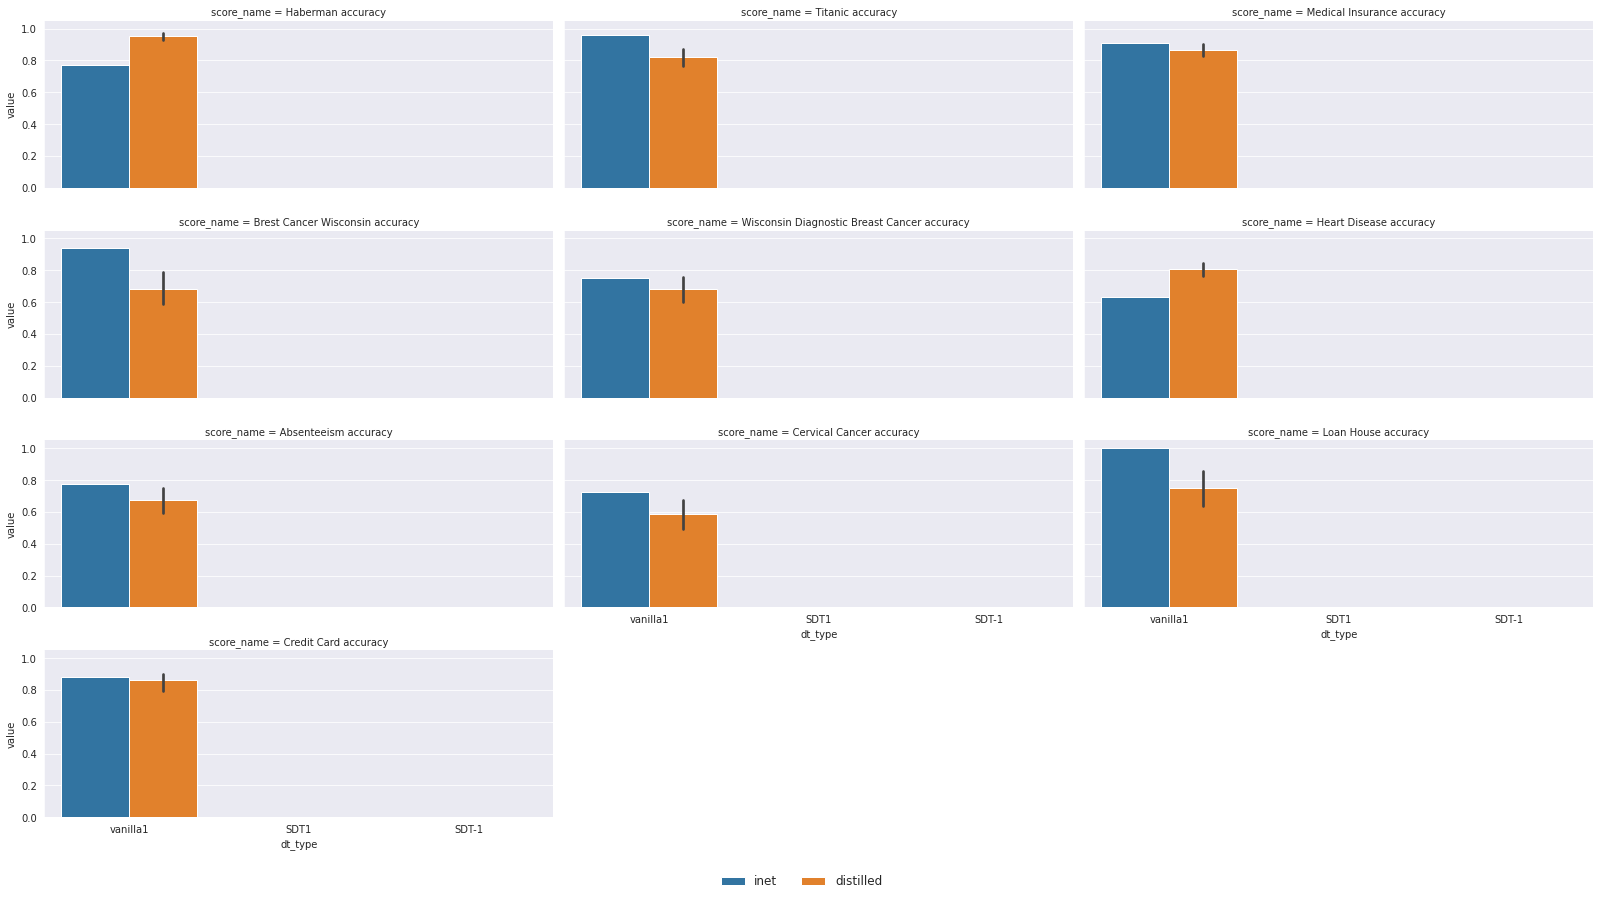

In [28]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'technique', 
                    plot_type = sns.barplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_barplot.pdf', bbox_inches = 'tight', pad_inches = 0)


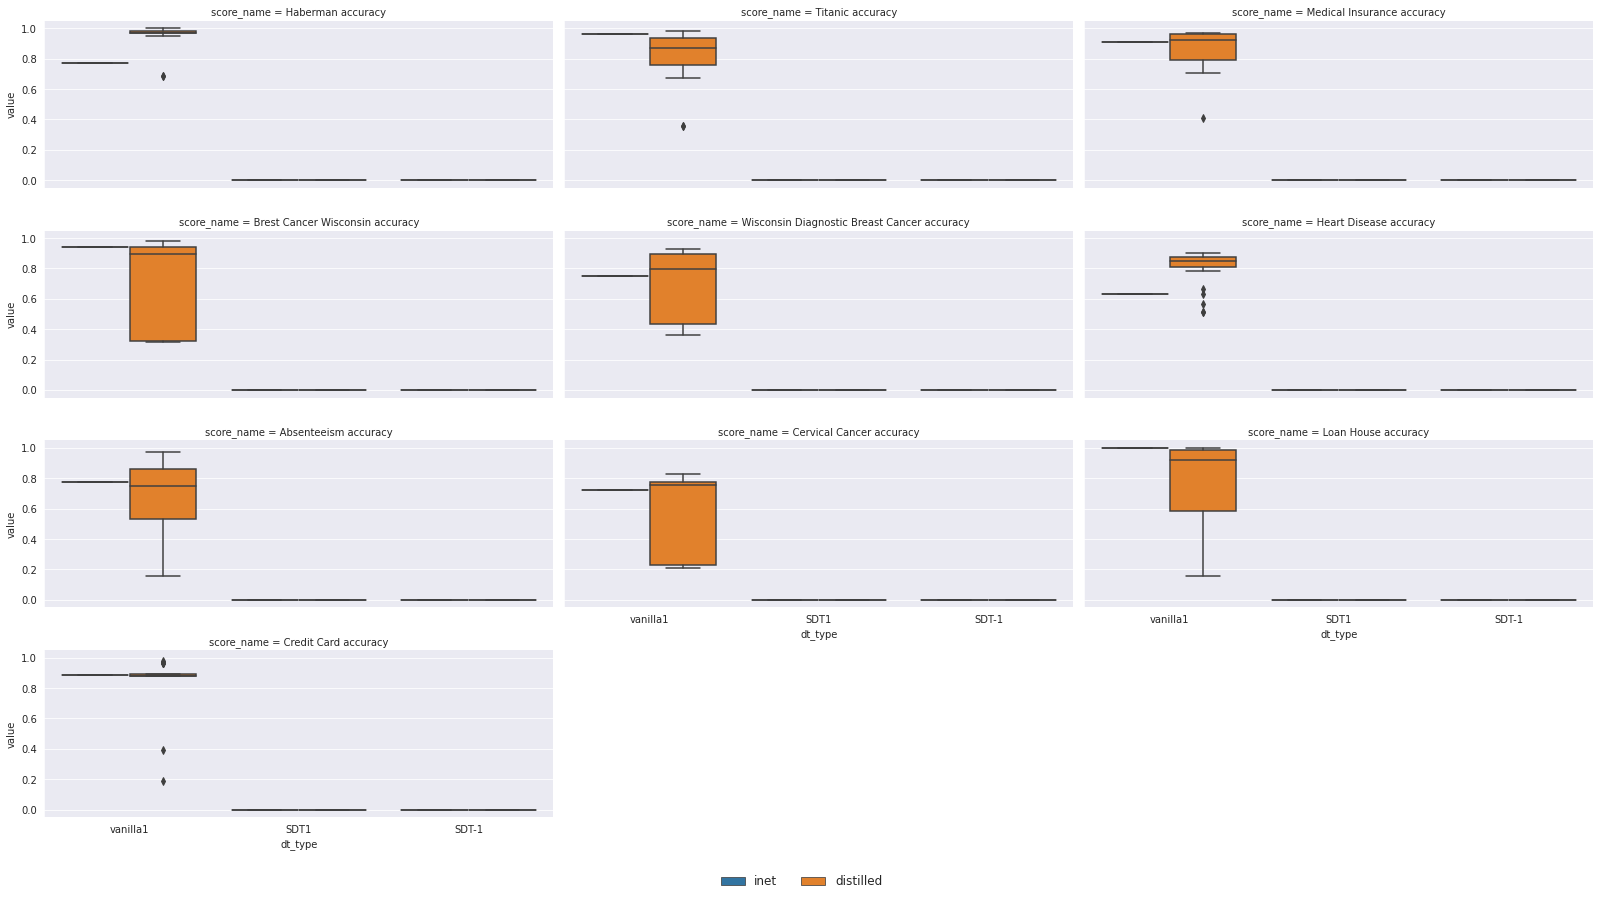

In [29]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'technique', 
                    plot_type = sns.boxplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_boxplot.pdf', bbox_inches = 'tight', pad_inches = 0)


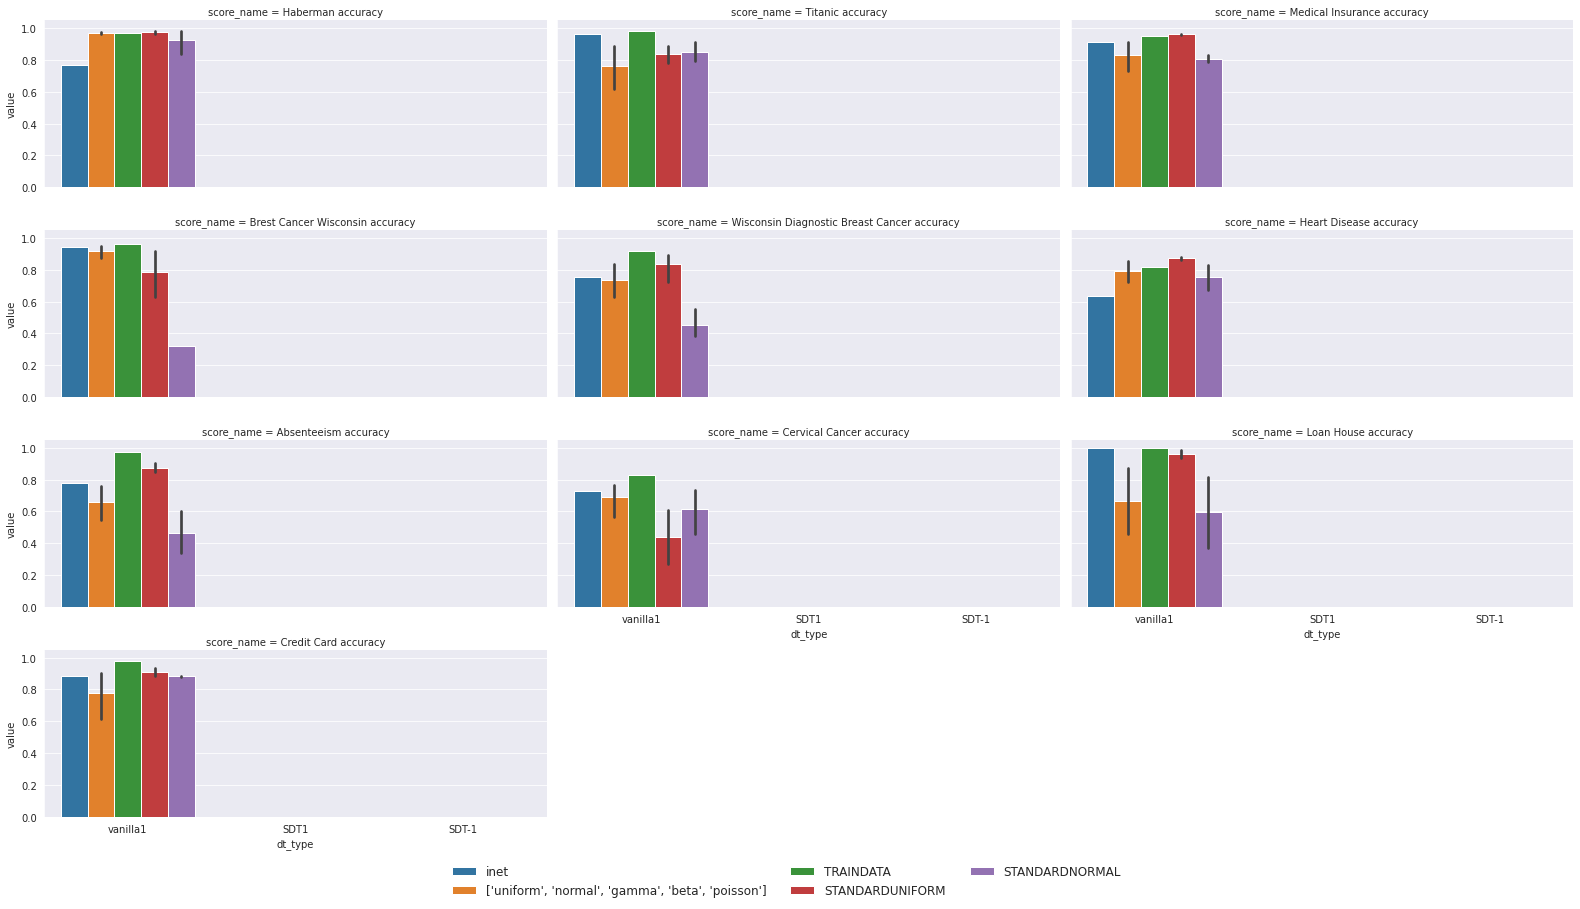

In [30]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'distrib', 
                    plot_type = sns.barplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_by_distrib_barplot.pdf', bbox_inches = 'tight', pad_inches = 0)


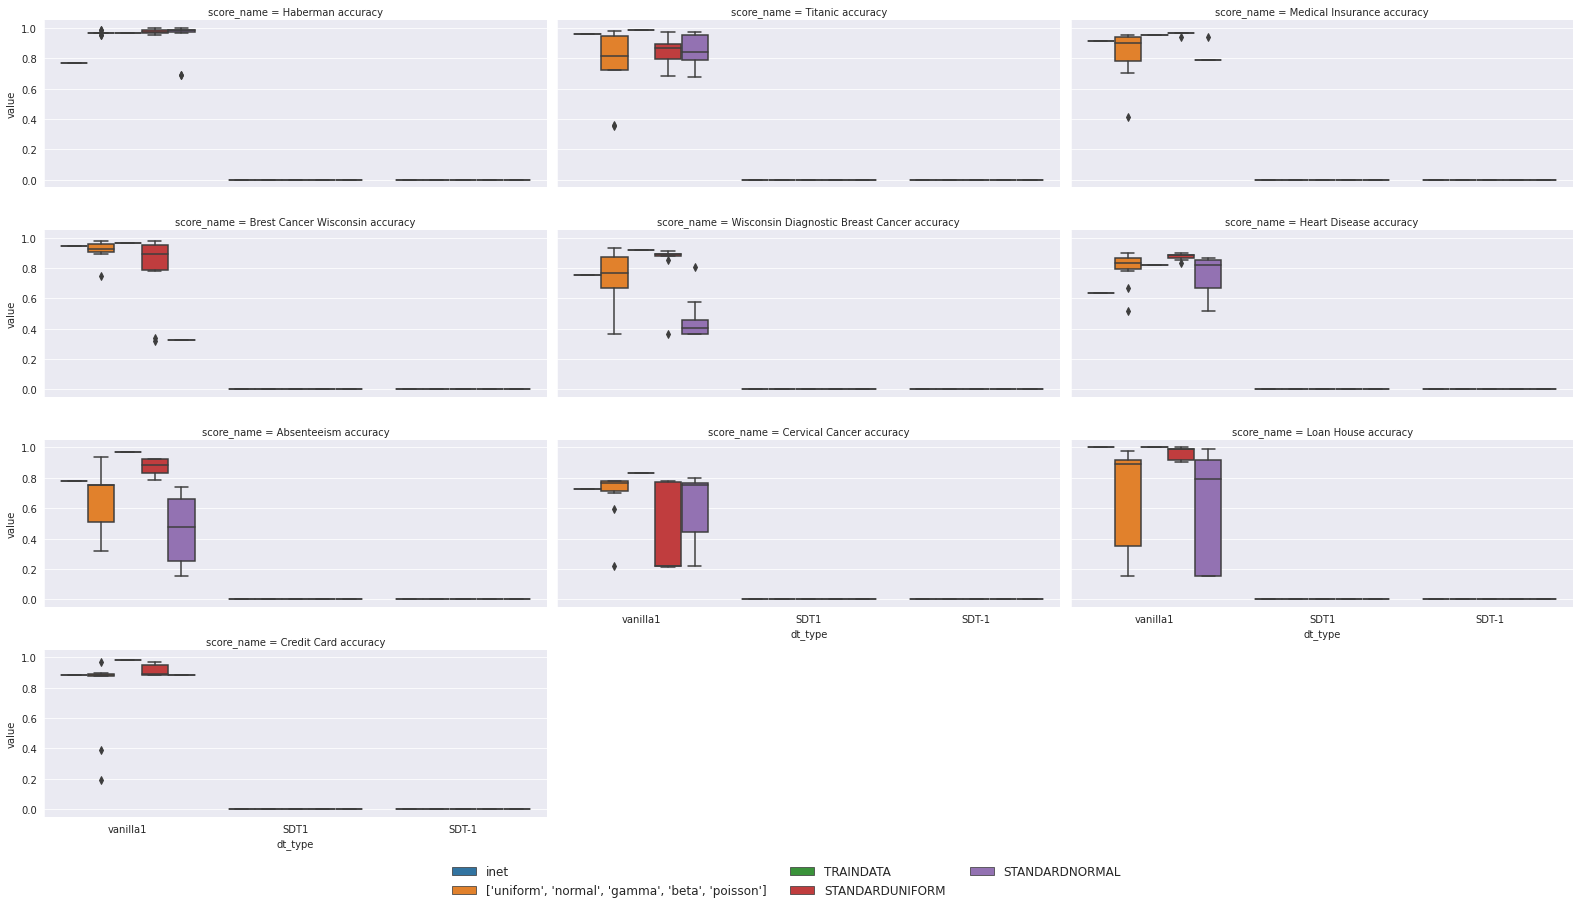

In [31]:
plot = plot_results(data_reduced=real_world_scores_df_distrib_adjusted_plotting, 
                    col = 'score_name', 
                    x = 'dt_type', 
                    y = 'value', 
                    hue = 'distrib', 
                    plot_type = sns.boxplot, 
                    aspect = 2.5, 
                    col_wrap = 3)

plt.savefig('./evaluation_results/' + timestr +'/real_workd_complete_by_technique_by_distrib_boxplot.pdf', bbox_inches = 'tight', pad_inches = 0)
